*A new Python package called [anjl](https://alimanfoo.github.io/anjl/) provides fast implementations of the neighbour-joining algorithm and interactive plotting of unrooted trees.*

---

In [1]:
%%html
<script>
MathJax = {
  tex: {
    inlineMath: [['$', '$']]
  },
  svg: {
    fontCache: 'global'
  }
};
</script>
<script type="text/javascript" id="MathJax-script" async
  src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-svg.js">
</script>
<script
src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.7/require.min.js"
integrity="sha512-J5ha2LF4Le+PBQnI5+xAVJDR+sZG9uSgroy4n/A6TLjNkvYQbqZA8WHZdaOvJ0HiKkBC9Frmvs10rFDSHKmveQ=="
crossorigin="anonymous"
referrerpolicy="no-referrer"></script>

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook_connected+plotly_mimetype"

Neighbour-joining trees (NJT) are a useful tool for exploratory analysis of genetic population structure. Previously I've used a Python package called [biotite](https://www.biotite-python.org/latest/index.html) to compute NJT, but recently I was trying to build some bigger trees and things started to take a long time to run. I decided to see if I could create a faster implementation, and so [anjl](https://alimanfoo.github.io/anjl/) was born...

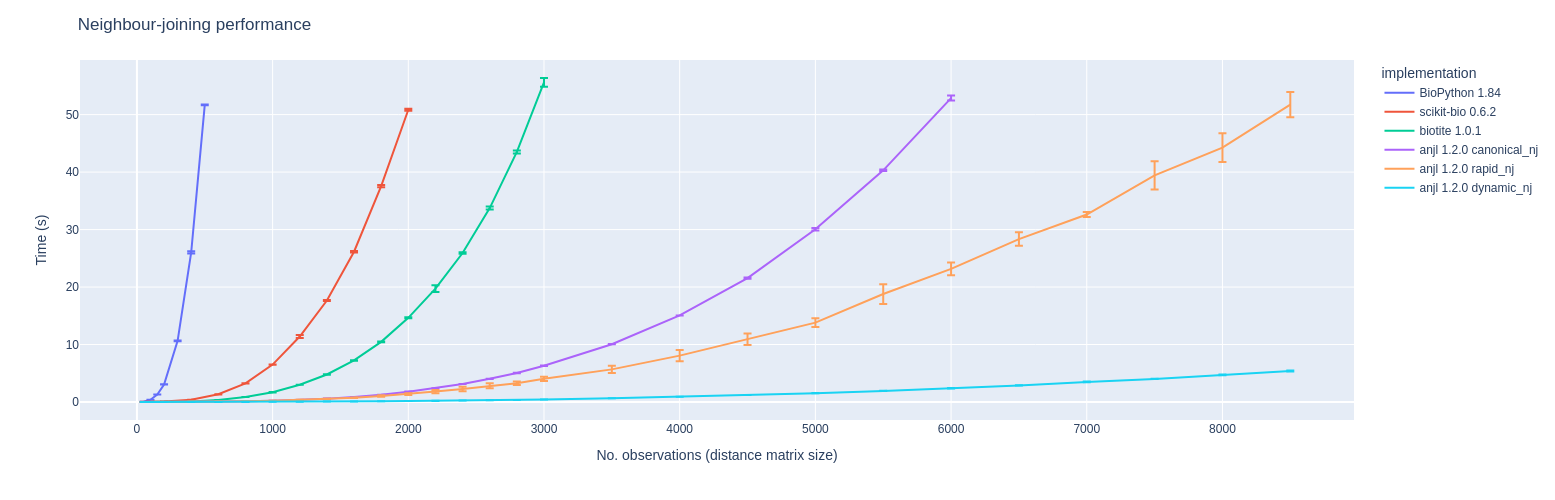

In [3]:
import pandas as pd
import plotly.express as px

df_results = pd.read_csv("results.csv")

df_plot = (
    df_results
    .groupby(["implementation", "size"])
    .agg(
        time_mean=("time", "mean"),
        time_std=("time", "std"),
    )
    .reset_index()
)

fig = px.line(
    df_plot,
    x="size",
    y="time_mean",
    error_y="time_std",
    width=800,
    height=500,
    color="implementation",
    category_orders=dict(
        implementation=[
            "BioPython 1.84",
            "scikit-bio 0.6.2",
            "biotite 1.0.1",
            "anjl 1.2.0 canonical_nj",
            "anjl 1.2.0 rapid_nj",
            "anjl 1.2.0 dynamic_nj",
        ]
    ),
)
fig.update_layout(
    title="Neighbour-joining performance",
    xaxis=dict(
        title="No. observations (distance matrix size)",
    ),
    yaxis=dict(
        title="Time (s)",
    ),
)
fig

## The canonical algorithm

Neighbour-joining is an iterative algorithm where each iteration involves searching a distance matrix for the pair of nearest neighbours which minimise a value $Q$, which are then joined to create a new internal node in the tree. The canonical algorithm performs a full search of the distance matrix in each iteration, and so expected performance is $O(n^3)$, meaning that speed of computation scales with the number of samples cubed. Thus even a very efficient implementation of the canonical algorithm will hit scalability limitations pretty quickly. Nevertheless, I thought I'd start with the canonical algorithm to have a reference implementation to compare to. After a bit of prototyping and tuning I had an implementation using [numba](https://numba.pydata.org/) that was around 10x faster than biotite. I decided this was worth packaging and so created a [new Python packaged called `anjl`](https://alimanfoo.github.io/anjl/) which stands for "A neighbour-joining library". 

## The rapid algorithm

I also found a [paper by Martin Simonsen et al. from 2008](https://pure.au.dk/ws/files/19821675/rapidNJ.pdf) describing a "rapid" neighbour-joining algorithm. This algorithm maintains a copy of the distance matrix where each row is sorted, and uses this to avoid doing a full search of the distance matrix in each iteration. I added a numba implementation of neighbour-joining based on Simonsen's algorithm to `anjl`. Benchmarking with some mosquito genomic data showed performance was more than 2x better the canonical algorithm for larger distance matrices. I was pretty happy with this, until...

## The dynamic algorithm

I probably should've searched harder before I started implementing the rapid algorithm, because I then found a [more recent paper by Philip Clausen](https://doi.org/10.1093/bioinformatics/btac774) describing a dynamic algorithm with some impressive benchmark results. The paper is pretty terse and it took a while to wrap my head around it, but a bit like staring at a magic eye picture, eventually it started to make sense. The basic insight is that the neighbour-joining criterion $Q$ is weakened at each iteration. This means that, if you start by finding the minimum value of $Q$ within each row of the distance matrix, then in the next iteration all values of $Q$ within the same row will be greater. In other words, the minimum value of $Q$ within each row provides a lower bound for all values of $Q$ in the next (and subsequent) iterations. You can use this information to skip over searching a lot of rows of the distance matrix at each iteration. The only exceptions to this rule are new nodes created during the neighbour-joining process, so you have to check if they create a better join. It's an amazing insight which is also beautifully simple to implement (when you get it!). And it's ridiculously fast, around 10x better than the rapid algorithm on the data I was using to benchmark with. 

## Interactive plotting

I also decided to include in `anjl` a function to visualise a NJT as an unrooted tree using [plotly](https://plotly.com/python/). Here plotly is useful because you can interact with the plot, hovering over leaf nodes to get more information, zooming and panning, and showing or hiding data via the legend. Here's a simple example. 

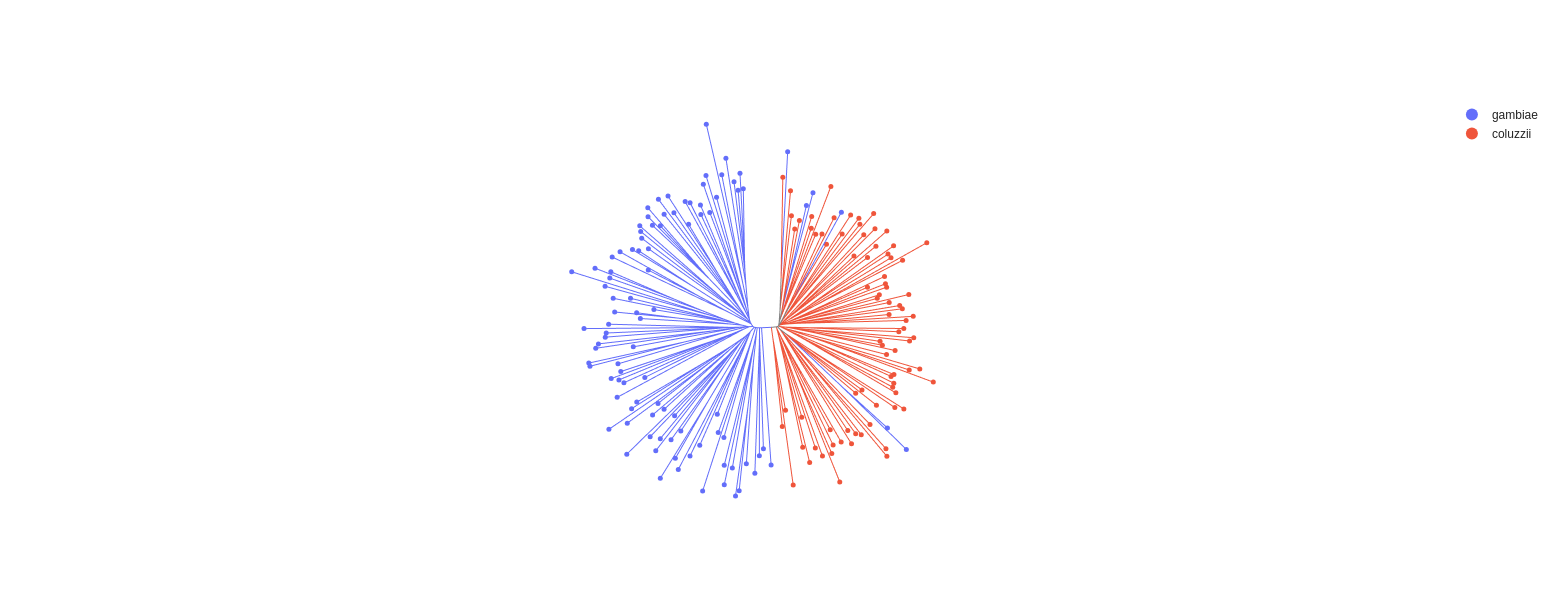

In [4]:
import anjl
D, leaf_data = anjl.data.mosquitoes()
Z = anjl.dynamic_nj(D)
anjl.plot(
    Z, 
    leaf_data=leaf_data, 
    color="taxon",
    hover_name="sample_id",
)

## Some numba lessons

I've used numba before but learned a couple of new things from working on this project.

### Boundscheck

By default, numba does **not** perform any checks to see if you are trying to index an array with a value that is too large (out of bounds). This is for performance reasons, otherwise the bounds checks would take some time. While I was working on the rapid algorithm I inadvertantly introduced an out of bounds indexing bug. I would expect this to cause program crashes, but actually the bug only caused a very occasional crash. It also didn't actually affect the correctness of the output. Long story short, it took me a while to figure out something was wrong. Eventually I realised I might have an indexing bug, and I set the `boundscheck` parameter to `True` in the number `njit()` decorator. Immediately this revealed that, yes, I had an index out of bounds error. 

The moral of the story is, it's probably a good idea to turn `boundscheck` on during development and when running tests. I ended up putting a conditional block in my code like this...

```python
# Detect whether we are running via pytest, if so run with boundscheck enabled to catch
# any out of bounds errors.
# https://docs.pytest.org/en/stable/example/simple.html#detect-if-running-from-within-a-pytest-run
if os.environ.get("PYTEST_VERSION") is not None:
    BOUNDSCHECK = True
else:
    BOUNDSCHECK = False
```

I then used this in all `njit` decorators, e.g.:

```python
@njit(
    boundscheck=BOUNDSCHECK,
)
def dynamic_search(...):
    ...
```

### Wraparound

When you are indexing an array, numba also checks to see if you are indexing with a negative value, in case it needs to handle wraparound logic (e.g., where a value like `-1` means the last value in the array). But this wraparound logic also takes some time, and if you're doing a lot of array access, this can affect performance. You can circumvent this by using unsigned integer data types for variables that you are using to index arrays. However, if you are using for loops in numba, the induction variable is a signed integer by default (although this is different for [parallel for loops](https://numba.readthedocs.io/en/stable/user/parallel.html)). You can get around this by casting the induction variable to an unsigned integer data type like `np.uintp`. E.g., all my for loops ended up looking like this...

```python
for _i in range(n):
    i = np.uintp(_i)
    # Use i for indexing arrays...
```

### Profiling 

What do you do if you think you've done everything you can to tune a numba function, but it's still running slower than you think it should? Ideally you'd do some profiling to find which section of code the program is spending most time in. While there are great tools for profiling normal Python code, there isn't yet a good tool for profiling code within a numba function. The only option I could find is a tool called [profila](https://github.com/pythonspeed/profila) which I did get to work some of the time, but which also [crashed a lot](https://github.com/pythonspeed/profila/issues/9). There is an [open feature request](https://github.com/numba/numba/issues/5028) on the numba github repo, it seems a better solution is possible but still some way off.

### Algorithm is everything

Of course the ultimately lesson here is that finding the right algorithm is potentially much more important than tuning tricks! The dynamic algorithm makes a massive difference, which is entirely due to an insight into the structure of the problem. 

## Further reading

* Clausen (2022) Scaling neighbor joining to one million taxa with dynamic and heuristic neighbor joining. https://doi.org/10.1093/bioinformatics/btac774
* Simonsen et al. (2008) Rapid neighbour-joining. https://pure.au.dk/ws/files/19821675/rapidNJ.pdf
* Numba: A high performance Python compiler. https://numba.pydata.org/